In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Create MATRIX data

In [2]:
rows, cols, sigma = 250, 100, 5.0
coefficients1 = [2,-1,-1] # of the shift polynomial

In [3]:
# define shift by passing coefficients in polynom
t_values = np.linspace(-10, 10, cols)
shifted_t_values = np.polyval(coefficients1,t_values)

In [4]:
# Gaussian function
def gaussian(x, mu, sigma=1.0):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

def create_gaussian_time_matrix(rows=500, cols=50, sigma=1.0):
    matrix = np.zeros((rows, cols))
    for col in range(cols):
        for row in range(rows):
            matrix[row, col] = gaussian(row, 20, sigma)
    matrix /= np.max(matrix)
    
    return matrix


In [5]:
Q_orig = create_gaussian_time_matrix(rows, cols, sigma)
qs = torch.tensor(Q_orig, requires_grad=False)

# Cubic spline interpolation class

In [6]:
class SplineInterpolation:
    def __init__(self, params):
        self.params = params
        self.A1, self.D1, self.D2, self.R = self.give_spline_coefficient_matrices()

    def give_spline_coefficient_matrices(self):
        Nxi = params['geometry']['Nxi']
        # Initialize matrices
        # Create the A1 matrix
        diagonals = np.ones((Nxi, 1)) * np.array([1, 2, 1])
        offsets = [-1, 0, Nxi-1]
        A1_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        A1 = torch.tensor(A1_np, dtype=torch.float64)

        # Create the D1 matrix
        diagonals = np.ones((Nxi, 1)) * np.array([-1, 1, -1])
        D1_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        D1 = torch.tensor(D1_np, dtype=torch.float64)

        # Create the D2 matrix
        diagonals = np.ones((Nxi, 1)) * np.array([1, 1, -2, 1, 1])
        offsets = [-(Nxi-1), -1, 0, 1, Nxi-1]
        D2_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        D2 = torch.tensor(D2_np, dtype=torch.float64)

        # Create the M matrix and compute its Cholesky decomposition
        diagonals = np.ones((Nxi, 1)) * np.array([1, 1, 4, 1, 1])
        M_np = diags(diagonals.T, offsets, shape=(Nxi, Nxi)).toarray()
        R_np = cholesky(M_np)
        R = torch.tensor(R_np, dtype=torch.float64)
        
        return A1, D1, D2, R

    def construct_spline_coeffs_periodic(self, qs):
        n = qs.shape[1]
        #import pdb; pdb.set_trace()
        # grid size:
        dxi = params['geometry']['dxi']

        # compute the spline coefficients:
        if qs.ndim == 1:  # case of just one data set
            spline_coeffs = {
                'a': qs,
                'c': (3 / dxi ** 2) * torch.solve(D2 @ qs, R)[0],
                'b': None,
                'd': None
            }
            spline_coeffs['b'] = (1 / dxi) * (self.D1 @ qs) + (dxi / 3) * (self.A1 @ spline_coeffs['c'])
            spline_coeffs['d'] = (1 / (3 * dxi)) * (self.D1 @ spline_coeffs['c'])
        else:  # case of multiple data sets
            spline_coeffs = {'a': qs, 'b': qs.clone(), 'c': qs.clone(), 'd': qs.clone()}
            #import pdb; pdb.set_trace()
            for i in range(n):
                # Assign the solved result to spline_coeffs
                spline_coeffs['c'][:, i] = (3 / dxi**2) * torch.linalg.solve(self.R, torch.linalg.solve(self.R.T, self.D2 @ qs[:, i]))
                spline_coeffs['b'][:, i] = (1 / dxi) * (self.D1 @ qs[:, i]) + (dxi / 3) * (self.A1 @ spline_coeffs['c'][:, i])
                spline_coeffs['d'][:, i] = (1 / (3 * dxi)) * (self.D1 @ spline_coeffs['c'][:, i])

        return spline_coeffs

    def forward(self, qs, cs):
        self.A1, self.D1, self.D2, self.R = self.give_spline_coefficient_matrices()
        # Compute spline coefficients
        spline_coeffs = self.construct_spline_coeffs_periodic(qs)

        # Shift the data set
        qs_shifted = self.shift_matrix_periodic_precomputed_coeffs(cs, spline_coeffs)
        return qs_shifted

    def backward(self, qs, cs):
        # Compute spline coefficients
        spline_coeffs = self.construct_spline_coeffs_periodic(qs)

        # Compute the derivative of the shifted data set
        qs_derivative_shifted = self.shiftMatrix_derivative_periodic_precomputedCoeffs(cs, spline_coeffs)
        return qs_derivative_shifted

    def shift_matrix_periodic_precomputed_coeffs(self, cs, spline_coeffs):
        # Extract spline coefficients
        a = spline_coeffs['a']
        b = spline_coeffs['b']
        c = spline_coeffs['c']
        d = spline_coeffs['d']

        # Number of grid points
        m = params['geometry']['Nxi']

        # Number of data sets
        n = a.shape[1]

        # Grid size
        dxi = params['geometry']['dxi']

        # Length of computational domain
        L = m * dxi

        # Compute csTilde = cs modulo L
        q1 = torch.floor(cs / L)
        csTilde = cs - q1 * L
        # Compute zeta = csTilde modulo dxi
        q2 = torch.floor(csTilde / dxi)
        zeta = csTilde - q2 * dxi

        # Compute shifted version of the data set(s)
        if a.ndim == 1:  # Case of only one data set
            if cs.ndim == 1:  # If cs is a vector, then the data set is shifted by multiple shift amounts
                zeta = zeta.reshape(1, -1)  # Ensure zeta is a row vector
                # Compute interpolated data set
                qsInterpolated = a - torch.matmul(b.unsqueeze(1), zeta) + torch.matmul(c.unsqueeze(1), zeta ** 2) - torch.matmul(d.unsqueeze(1), zeta ** 3)
                # Compute shifted data set
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)

            else:
                qsInterpolated = a - zeta * b + zeta ** 2 * c - zeta ** 3 * d
                qsShifted = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]))
        else:  # Case of multiple data sets
            if torch.is_tensor(q2) and q2.numel() == 1:
                q2 = q2.repeat(n)
                zeta = zeta.repeat(n)
            qsShifted = torch.zeros((m, n))
            for i in range(n):
                # Compute interpolated data set
                qsInterpolated = a[:, i] - zeta[i] * b[:, i] + zeta[i] ** 2 * c[:, i] - zeta[i] ** 3 * d[:, i]
                # Compute shifted data set
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)


        return qsShifted

    def shiftMatrix_derivative_periodic_precomputedCoeffs(self, cs, splineCoeffs):
        # Extracting spline coefficients
        b = splineCoeffs['b']
        c = splineCoeffs['c']
        d = splineCoeffs['d']
        
        # Number of grid points
        m = params['geometry']['Nxi']

        # Number of data sets
        n = b.shape[1]

        # Grid size
        dxi = params['geometry']['dxi']

        # Length of computational domain
        L = m * dxi

        # Compute csTilde = cs modulo L
        q1 = torch.floor(cs / L)
        csTilde = cs - q1 * L

        # Compute zeta = csTilde modulo dxi
        q2 = torch.floor(csTilde / dxi)
        zeta = csTilde - q2 * dxi
        #import pdb; pdb.set_trace()

        # Compute derivative of shifted data set(s)
        if b.dim() == 1:  # Case of only one data set
            if cs.dim() == 1:  # if cs is a vector
                if zeta.dim() == 1:
                    zeta = zeta.unsqueeze(0)
                qsInterpolated = -b + 2 * c * zeta - 3 * d * zeta.pow(2)
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)
            else:
                qsInterpolated = -b + 2 * zeta * c - 3 * zeta.pow(2) * d
                qsShifted = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]))
        else:  # Case of multiple data sets
            if torch.is_tensor(q2) and torch.numel(q2) == 1:
                q2 = q2.repeat(n)
                zeta = zeta.repeat(n)
            qsShifted = torch.zeros((m, n), dtype=b.dtype, device=b.device)
            for i in range(n):
                qsInterpolated = -b[:, i] + 2 * zeta[i] * c[:, i] - 3 * zeta[i].pow(2) * d[:, i]
                qsShifted[:, i] = torch.cat((qsInterpolated[m - int(q2[i].item()):], qsInterpolated[:m - int(q2[i].item())]), dim=0)

        return qsShifted

## Define parameters for spline interpolation

In [7]:
x = np.arange(0,rows)
cs = torch.tensor(shifted_t_values, requires_grad=True)
dx = x[1] - x[0]
params = {'geometry': {'Nxi': rows, 'dxi': dx}, 'interpolation': {}}

In [8]:
spline_interpolator = SplineInterpolation(params)
qs_shifted = spline_interpolator.forward(qs.double(), cs.double()) # shifted snapshot matrix
q_reverse_shifted = spline_interpolator.forward(qs_shifted.double(), -cs.double()) # shift shifted snapshot matrix back
qs_derivative_shifted = spline_interpolator.backward(qs.double(), cs.double()) # derivative of shifted snaphot matrix

In [9]:
# Relative error
print(np.linalg.norm(qs.detach().numpy() - q_reverse_shifted.detach().numpy())/np.linalg.norm(qs.detach().numpy()))

1.52779350620061e-05


Text(0.5, 1.0, 'Snapshot Matrix with Polynomial Shift')

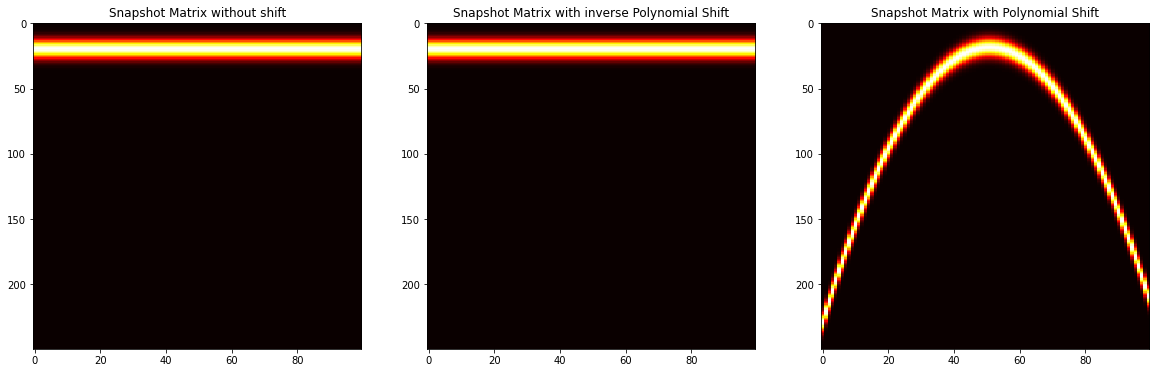

In [10]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Without shift
ax[0].imshow(qs.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Snapshot Matrix without shift')

# With inverse shift
ax[1].imshow(q_reverse_shifted.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Snapshot Matrix with inverse Polynomial Shift')

# With shift
ax[2].imshow(qs_shifted.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[2].set_title('Snapshot Matrix with Polynomial Shift')

## Check if gradients for spline interpolation are calculated correctly

In [39]:
#from torch.autograd import gradcheck

#spline_interpolator = SplineInterpolation(params)

#test = gradcheck(spline_interpolator.backward, (qs.double(), cs.double()), eps=1e-5)
#print("Gradient check passed:", test)


## Define a shift model

In [40]:
class ShiftPredictionModel(nn.Module):
    def __init__(self, p_init_coeffs):
        super(ShiftPredictionModel, self).__init__()
        self.p_coefficients = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float64), requires_grad=True) for coeff in p_init_coeffs[::-1]]
        )
    def forward(self,t):
        return sum([coeff * t**i for i, coeff in enumerate(self.p_coefficients)])


## Define Nuclear Norm class

In [41]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=True)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag_embed((s > 0).to(dtype))[:s.size(0), :s.size(0)]
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output

## Check if gradients for nuclear norm are calculated correctly

In [42]:
#input_matrix = torch.randn(5, 5, dtype=torch.double, requires_grad=True) #torch.tensor(qs, dtype=torch.double, requires_grad=True)

#gradcheck_success = gradcheck(NuclearNormAutograd.apply, input_matrix, eps=1e-05, atol=1e-4)
#print("Gradient check passed:", gradcheck_success)

## Train a model

In [64]:
p_coefficients_init = [0,-1,0.5] # initial coefficients of a shift polynomial
t_values_tensor = torch.linspace(-10, 10, cols,dtype=torch.float64)

In [66]:
model = ShiftPredictionModel(p_init_coeffs=p_coefficients_init)
model.to(torch.float64)

optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(), lr=0.001)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred_pol = model(t_values_tensor) # model give a shift vector (for degree 2: (y=a1*t+a0))
    p_coefficients = torch.tensor([p.item() for p in model.p_coefficients]) # get coefficients for the visualisation
    TQ = spline_interpolator.forward(qs_shifted.double(), -y_pred_pol.double()) # calculate T^-1(Q)
    loss = NuclearNormAutograd.apply(TQ)
    #loss = torch.norm(TQ - qs, 'fro')**2 # calculate ||T^-1(Q) - Q1||
    #loss = criterion(y_pred_pol, torch.tensor(shifted_t_values))
    
    loss.backward(retain_graph=True)

    optimizer.step()
    
    #scheduler.step()
            
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f},Coefficients:{[coefficients1[::-1][i] for i in range(len(coefficients1))]}{p_coefficients}')

print(f"Model training complete.")

Epoch [0/1000], Loss: 137.5324,Coefficients:[-1, -1, 2]tensor([ 0.5000, -1.0000,  0.0000])
Epoch [100/1000], Loss: 97.1825,Coefficients:[-1, -1, 2]tensor([ 0.5678, -1.0006,  1.0781])
Epoch [200/1000], Loss: 30.2922,Coefficients:[-1, -1, 2]tensor([ 0.4521, -0.9998,  2.0041])
Epoch [300/1000], Loss: 29.9548,Coefficients:[-1, -1, 2]tensor([ 0.4190, -1.0007,  1.9986])


KeyboardInterrupt: 

Text(0.5, 1.0, 'Shifted Snapshot with initial shift T^-1(Q)')

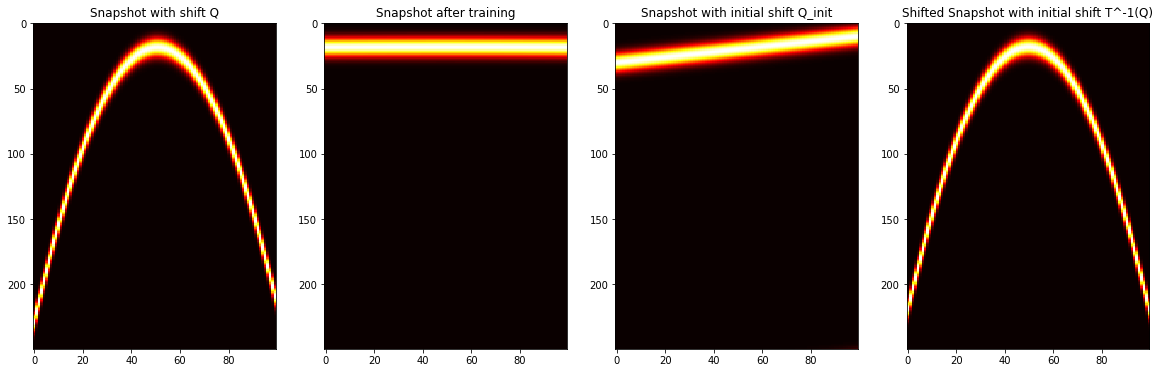

In [67]:
# Plotting
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

# Without shift
ax[0].imshow(qs_shifted.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Snapshot with shift Q')

# With shift
ax[1].imshow(TQ.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Snapshot after training')

# With initial shift
initial_cs = torch.tensor(np.polyval(p_coefficients_init,t_values), requires_grad=True)
qs_initial_shift = spline_interpolator.forward(qs.double(), initial_cs.double())
ax[2].imshow(qs_initial_shift.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[2].set_title('Snapshot with initial shift Q_init')

# With initial shift
qs_shifted_initial_shift = spline_interpolator.forward(qs_shifted.double(), -initial_cs.double())
ax[3].imshow(qs_shifted_initial_shift.detach().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
ax[3].set_title('Shifted Snapshot with initial shift T^-1(Q)')

In [68]:
NuclearNormAutograd.apply(qs) - loss

tensor(-0.2125, dtype=torch.float64, grad_fn=<SubBackward0>)

# Visualisation

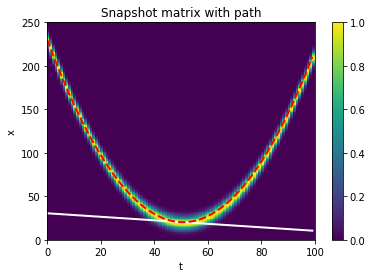

In [69]:
center_of_matrix = 20

shift_vector_initial = center_of_matrix + initial_cs.detach().numpy()
x_values = np.arange(cols)
shift_vector_after_training = center_of_matrix + np.polyval(p_coefficients.detach().numpy()[::-1],t_values)

plt.pcolor(qs_shifted.detach().numpy(), shading='auto')
plt.colorbar()
plt.plot(x_values, shift_vector_initial, 'w-', linewidth=2)
plt.plot(x_values, shift_vector_after_training, 'r--', linewidth=2)

plt.title('Snapshot matrix with path')
plt.xlabel('t')
plt.ylabel('x')
plt.show()